[*********************100%%**********************]  11 of 11 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_4616\1390868549.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Optimal weights for the assets:
SPY: 0.0166
BABA: 0.0000
TM: 0.1640
TCS.NS: 0.2134
SIE.DE: 0.3090
^TYX: 0.0141
^IRX: 0.1730
EURUSD=X: 0.1037
JPY=X: -0.0000
AUDUSD=X: 0.0062
BRL=X: -0.0000

Expected portfolio return: 12.00%
Expected portfolio volatility: 7.27%
Sharpe Ratio: 1.65


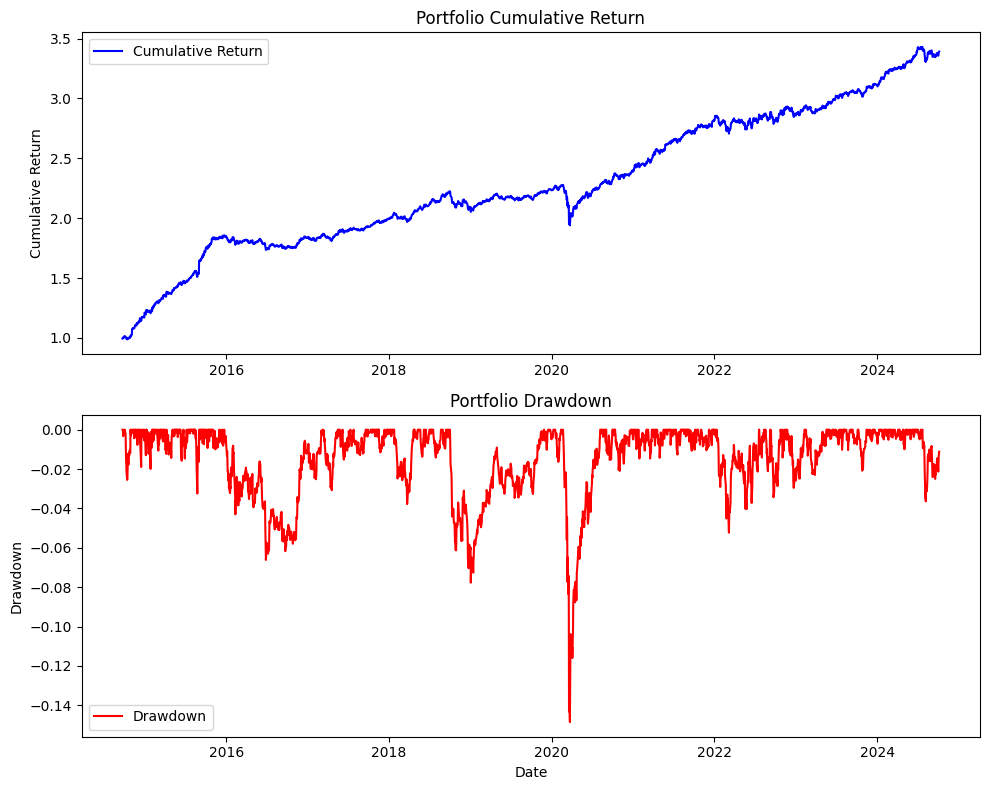

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# List of selected tickers
tickers = [
    'SPY', 'BABA', 'TM', 'TCS.NS', 'SIE.DE',  # Shares
    '^TYX', # Long term bonds
    '^IRX', # Short term bonds
    'EURUSD=X', 'JPY=X', 'AUDUSD=X', 'BRL=X'  # Forex
]

# Download adjusted close price data
data = yf.download(tickers, period="max")['Adj Close']

# Calculate daily returns of the assets
returns = data.pct_change().dropna()

# Model parameters
expected_return = 0.12 / 252  # Daily return (12% annual)
risk_free_rate = 0.05 / 252  # Risk-free rate (5% annual)
n_assets = len(tickers)

# Optimization variables: portfolio weights
weights = cp.Variable(n_assets)

# Objective function: minimize volatility
portfolio_variance = cp.quad_form(weights, np.cov(returns.T))
objective = cp.Minimize(portfolio_variance)

# Constraints: weights must sum to 1 and expected return must meet the target
constraints = [
    cp.sum(weights) == 1,
    cp.matmul(returns.mean().values, weights) >= expected_return,
    weights >= 0  # Non-negative weights (no short selling)
]

# Define and solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Results
optimal_weights = weights.value
portfolio_return = np.dot(returns.mean().values, optimal_weights) * 252
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(np.cov(returns.T), optimal_weights)) * 252)

# Calculate the Sharpe ratio
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

# Display results
print("Optimal weights for the assets:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

print(f"\nExpected portfolio return: {portfolio_return:.2%}")
print(f"Expected portfolio volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Portfolio weighted returns
weighted_returns = returns.dot(optimal_weights)

# Cumulative return
cumulative_return = (1 + weighted_returns).cumprod()

# Drawdown (maximum decline from a peak)
rolling_max = cumulative_return.cummax()
drawdown = (cumulative_return - rolling_max) / rolling_max

# Plot cumulative return and drawdown
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Cumulative return
ax[0].plot(cumulative_return, label='Cumulative Return', color='blue')
ax[0].set_title('Portfolio Cumulative Return')
ax[0].set_ylabel('Cumulative Return')
ax[0].legend()

# Drawdown
ax[1].plot(drawdown, label='Drawdown', color='red')
ax[1].set_title('Portfolio Drawdown')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].legend()

plt.tight_layout()
plt.show()
